# Modeling the spread of Covid-19 in the U.S. with varying levels of social distancing forecasted by mobility data

### CS 109b Final Project, Module D

Seth Billiau, Daphne Kaxiras, Nick Lepore, Sarah Lucioni

## Introduction

When faced with a real-time epidemic, it is challenging to forecast the population-level disease activity because many important details about the disease are unknown. This uncertainty makes it hard to recommend courses of action for each population. Additionally, the uncertain movement and reaction of people affects the short-term forecast of the disease activity. 

The Module D project motivated our team to apply machine learning techniques and Internet-based data sources for real-time monitoring and short-term forecasting of population-level disease activity as well as design and deploy a predictive model to track and forecast epidemic outbreaks in real time. The COVID-19 epidemic has unfolded in 2020 unfortunately giving us the exact opportunity to track and forecast an epidemic outbreak in real time. 

COVID-19 is caused by the SARS-CoV-2 coronavirus. The first case appeared in December 2019 in Wuhan, China. In the United States, the first confirmed case occurred on January 21, 2020. Action within the U.S. was not taken quickly resulting in contaminated and slow testing, varied state-level responses, and an extreme growth in cases compared to other countries with similar timelines. Furthermore, the economy has struggled and is heading toward recession. The lockdown of the entire nation has not occurred, leaving lockdown decisions to each individual state. Many states began restricting movement in mid March. As of early May, states are looking to lift lockdowns in hopes of repairing the economic destruction even though testing struggles are still apparent, a vaccine does not exist, and the overall spread of COVID-19 has not miraculously improved.

The struggling response in the United States has influenced our team's project. We aim to use Google and Apple mobility data as a proxy for the level of social distancing within the U.S. in order to estimate the changing $R_0$ (the expected number of people an infected person infects) in an SIR model. We will then exhibit three social distancing scenarios: staying in lockdown, slowly lifting lockdown, and immediately lifting lockdown. For each of the three social distancing measures, we will use the SIR model with $R_0$ mobility proxy to forecast the corresponding spread of COVID-19 in the United States. We hope that these forecasts will show the importance and necessity of staying in a lockdown in order to flatten the curve of infection which will help to not overwhelm health care facilities.  



**Works Cited**
- [“WHO Timeline - COVID-19.” World Health Organization, World Health Organization.](https://www.who.int/news-room/detail/27-04-2020-who-timeline---covid-19)
- [“First Travel-Related Case of 2019 Novel Coronavirus Detected in United States.” Centers for Disease Control and Prevention, Centers for Disease Control and Prevention, 21 Jan. 2020.](https://www.cdc.gov/media/releases/2020/p0121-novel-coronavirus-travel-case.html)
- [Al Jazeera. “Lockdowns, Closures: How Is Each US State Handling Coronavirus?” USA News | Al Jazeera, Al Jazeera, 14 Apr. 2020.](https://www.aljazeera.com/news/2020/03/emergencies-closures-states-handling-coronavirus-200317213356419.html)

## Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.integrate import odeint

from fbprophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING) 

## EDA

In order to narrow our project scope and decide on our model, we looked at many datasets. Originally, we investigated the COVID-19 dataset from John Hopkins University Center for Systems Science and Engineering as well as the Midas Network's COVID-19 dataset to understand how the epidemic was unfolding. We also explored the weighted Influenza like illness (wILI) data to better understand how seasonal contagious diseases change over time. These three datasets helped us learn to work with time-series data. The two COVID-19 datasets narrowed our project interest to the United States because the U.S. trend and response was increasingly different from other countries.

First, let us prepare the data so that we can analyze it.

In [2]:
## Clean data

# Most recent report
today = datetime.now()

# Daily report 
recent_dr = pd.read_csv(f'../covid/CSSEGIS_COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/0{today.month}-0{today.day - 1}-{today.year}.csv')
recent_dr_by_country = recent_dr.groupby(['Country_Region']).sum().reset_index()

# Time Series - Global confirmed cases
ts_global_confirmed = pd.read_csv('../covid/CSSEGIS_COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
ts_global_confirmed_by_country = ts_global_confirmed.groupby(['Country/Region']).sum().reset_index()
top10cases = recent_dr_by_country.sort_values(by = ['Confirmed'], ascending = False).head(10)
ts_top10confirmed = ts_global_confirmed_by_country.loc[ts_global_confirmed_by_country['Country/Region'].isin(top10cases.Country_Region)]
ts_global_deaths = pd.read_csv('../covid/CSSEGIS_COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
ts_global_death_by_country = ts_global_deaths.groupby(['Country/Region']).sum().reset_index()
ts_top10deaths = ts_global_death_by_country.loc[ts_global_death_by_country['Country/Region'].isin(top10cases.Country_Region)]
ts_global_recovered = pd.read_csv('../covid/CSSEGIS_COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
ts_global_recovered_by_country = ts_global_recovered.groupby(['Country/Region']).sum().reset_index()
df_currentlysick = ts_global_confirmed_by_country.T[3:].T - ts_global_recovered_by_country.T[3:].T - ts_global_death_by_country.T[3:].T
df_left = ts_global_confirmed_by_country.T[:3].T
ts_currentlysick = pd.concat([df_left, df_currentlysick], axis = 1, sort = False) 


The resulting graphics give a snapshot of the global distribution of COVID-19 on April 12, 2020. We can modify the code used to produce these to suit any date back to January 22, 2020. 

In [3]:
## Plot of confirmed Covid-19 cases on April 12, 2020
# TODO - add Seth map graphic (confirmed cases)

In [4]:
## Plot of Covid-19 deaths on April 12, 2020
# TODO - add Seth map graphic (deaths)

To understand the relative number of cases in the United States vs. the rest of the world, let us look at a histogram of the amount of cases, deaths, and recoveries in the 10 countries with the leading amount of cases:

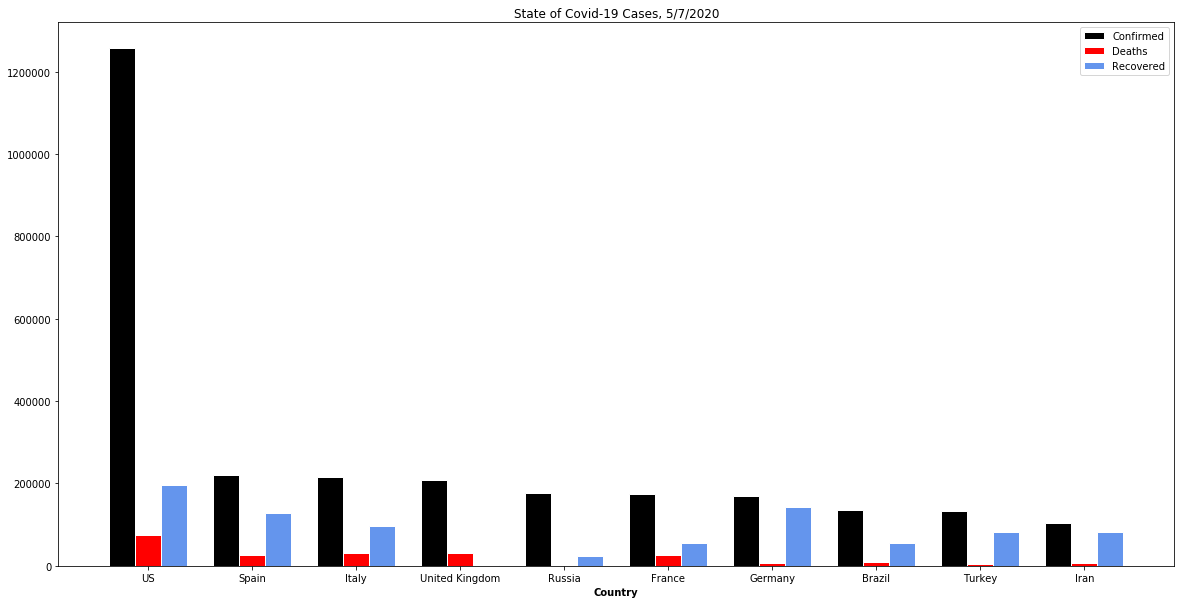

In [5]:
## Histogram of cases, deaths, recoveries in top 10 affected countries

# set width of bar
plt.figure(figsize=(20,10))
barWidth = 0.25
 
# Set position of bar on X axis
confirmed = np.arange(10)
deaths = [x + barWidth for x in confirmed]
recovered = [x + barWidth for x in deaths]
 
# Make the plot
plt.bar(confirmed, top10cases.Confirmed, color="black", width=barWidth, edgecolor='white', label='Confirmed')
plt.bar(deaths, top10cases.Deaths, color="red", width=barWidth, edgecolor='white', label='Deaths')
plt.bar(recovered, top10cases.Recovered, color='cornflowerblue', width=barWidth, edgecolor='white', label='Recovered')
 
# Add xticks on the middle of the group bars
plt.xlabel('Country', fontweight='bold')
plt.xticks([r + barWidth for r in range(10)], top10cases.Country_Region)
 
# Create legend & Show graphic
plt.legend()
plt.title(f"State of Covid-19 Cases, {today.month}/{today.day - 1}/{today.year}")
plt.show()

We observe the sheer multitude of cases in the United States compared to the other countries. It is interesting to note that while the number of cases in the US far exceeds the other countries, the number of deaths and recoveries is similar to the other countries. It is also interesting to note how the recovered cases and deaths do not reflect the majority of the confirmed cases therefore highlighting that many people are still actively sick. Furthermore, we can see that Germany has had a strong response in comparison to other countries because even though Germany has a similar amount of cases to France, Italy, and Spain, the recovered cases are much higher and the deaths are much lower.

Now, let us look at a time series of the confirmed cases across the 10 countries with the leading amount of cases:

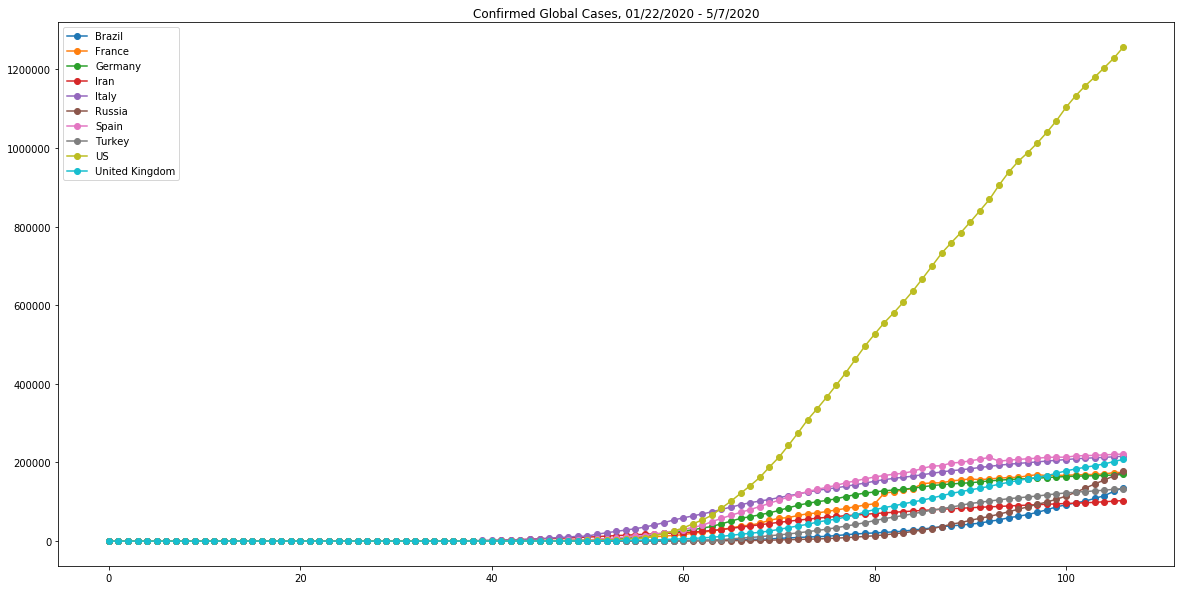

In [6]:
## Confirmed cases across the 10 most affected countries

plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(range(len(ts_top10confirmed.T[3:])), ts_top10confirmed.T[3:].T.iloc[i], marker = 'o', 
             label = ts_top10confirmed['Country/Region'].iloc[i])

plt.legend()
plt.title(f"Confirmed Global Cases, 01/22/2020 - {today.month}/{today.day - 1}/{today.year}")
plt.show()

From this visualization, we see that the United States has drastically more cases that have spread at a more exponential rate. While this is shocking, we also have to consider that many people are not being tested. Therefore, the US figure is most likely an undercounted representation of what is actually happening. 

No one knows the true fatality of Covid-19. In order to understand how the rate is changing globally, we looked at the death rate (amount of deaths /amount of confirmed cases) for the 10 countries with the leading amount of cases:

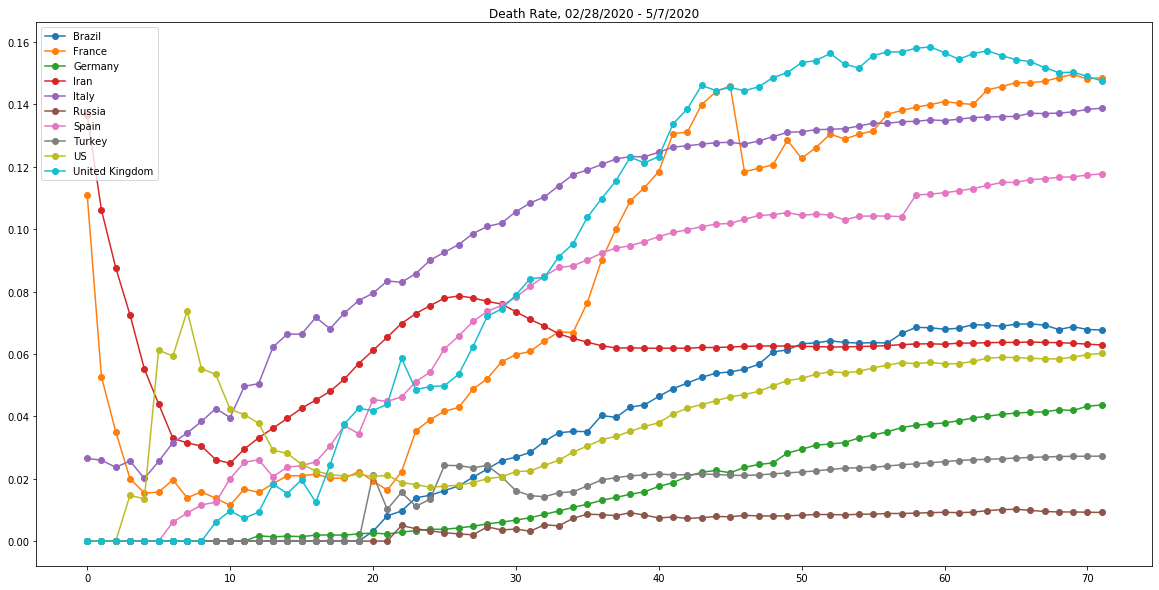

In [7]:
## Estimated death rate across the 10 most affected countries

df_death_rate = ts_top10deaths.T[3:].T / (ts_top10confirmed.T[3:].T + 0.000001)
df_left = ts_top10deaths.T[:3].T
ts_top10_death_rate = pd.concat([df_left, df_death_rate], axis = 1, sort = False) 

plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(range(len(ts_top10_death_rate.T[38:])), ts_top10_death_rate.T[38:].T.iloc[i], marker = 'o', 
             label = ts_top10_death_rate['Country/Region'].iloc[i])

plt.legend()
plt.title(f"Death Rate, 02/28/2020 - {today.month}/{today.day - 1}/{today.year}")
plt.show()

The sheer fluctuation shows how the fatality rate is still unknown and that it varies by country. However, it is apparent that the general trend of the death rate is still increasing. Again, note that the number of confirmed cases is undercounted, so the true death rate is most likely a lower than estimated above.

Narrowing our scope, let us look at three countries which have been prevalent in the news: China, Italy, and the United States. Let us visualize the amount of confirmed cases versus the amount of active cases. Active cases are those who still have the disease (so confirmed - [death + recovery]).

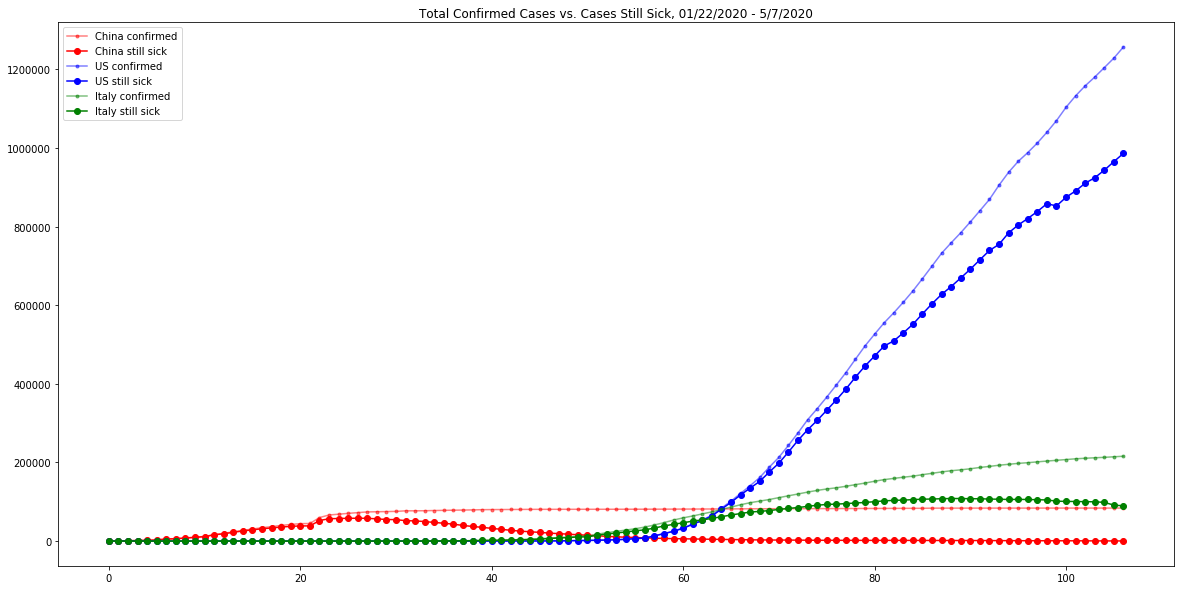

In [8]:
## US vs. China vs. Italy trends

countries_to_plot = ['China', 'US', 'Italy']
color_per_country = ['red', 'blue', 'green']
plt.figure(figsize=(20,10))
for i, country in enumerate(countries_to_plot):
    plt.plot(range(len(ts_top10confirmed.T[3:])), 
             ts_global_confirmed_by_country.T[3:].T.loc[ts_global_confirmed_by_country['Country/Region'] == country].values.reshape(-1), 
             marker = '.', label = country + " confirmed", color = color_per_country[i], alpha = 0.5)
    plt.plot(range(len(ts_currentlysick.T[3:])), 
             ts_currentlysick.T[3:].T.loc[ts_currentlysick['Country/Region'] == country].values.reshape(-1), 
             marker = 'o', label = country + " still sick", color = color_per_country[i])

plt.legend()
plt.title(f"Total Confirmed Cases vs. Cases Still Sick, 01/22/2020 - {today.month}/{today.day - 1}/{today.year}")
plt.show()

From this visualization, we see that China has either contained the virus or is not accurately releasing their numbers. We can also see that the number of people sick in Italy has started to noticeably deviate from the confirmed cases. Hopefully, this trend continues and shows that Italy hit their peak amount of sick cases. In the United States, the deviation is not apparent. Furthermore, the U.S. cases are much more drastic compared to Italy and China. This unfortunately highlights that the U.S. is still on an upward trend of sick cases.

The above EDA helped us narrow our project scope to the United States. We then looked into the mobility data from [Google](https://www.google.com/covid19/mobility/) and [Apple](https://www.apple.com/covid19/mobility) in order to better understand the movement of U.S. residents. 

Both datasets show the change in movement of different categories (such as transit) from a baseline value. According to Google, the baseline used in the mobility report is ''the median value for the corresponding day of the week, during the 5-week period Jan 3 - Feb 6, 2020.''

In [14]:
def get_country_mobility(country):
    return google_mobility.iloc[np.where(google_mobility.country_region == country)]

In [15]:
## Mobility data

# Different mobility categories by dataset  
data_columns_google = ['retail_and_recreation_percent_change_from_baseline',
                       'grocery_and_pharmacy_percent_change_from_baseline',
                       'parks_percent_change_from_baseline',
                       'transit_stations_percent_change_from_baseline',
                       'workplaces_percent_change_from_baseline',
                       'residential_percent_change_from_baseline']

data_columns_apple = ['driving', 'transit', 'walking']


# Google Mobility
google_mobility = pd.read_csv('data/Global_Mobility_Report.csv')
google_us = get_country_mobility('United States')
us_overall_google = google_us.iloc[np.where(google_us.sub_region_1.astype('str') == 'nan')]
us_overall_google = us_overall_google.set_index('date')

# Apple Mobility
apple_mobility = pd.read_csv('data/applemobilitytrends-2020-05-03.csv')  # update the date to match
apple_us = apple_mobility[apple_mobility['region'] == 'United States']
apple_us_total = apple_us[apple_us['geo_type'] == 'country/region']
transposed_apple = apple_us_total.drop(columns=['geo_type', 'region', 'alternative_name']).T
transposed_apple = transposed_apple.reset_index().rename(columns={'index': 'date', 146: 'driving', 147: 'transit', 148:'walking'}).iloc[1:]
transposed_apple[data_columns_apple] = transposed_apple[data_columns_apple].astype('float64')
transposed_apple = transposed_apple.set_index('date')
transposed_apple = transposed_apple - 100  # center to reflect the google mobility data structure


# Compute the centered 7-day rolling mean
us_overall_7d_google = us_overall_google[data_columns_google].rolling(7, center=True).mean()
us_overall_7d_apple = transposed_apple[data_columns_apple].rolling(7, center=True).mean()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
def plot_daily_rolling(df, col_name_lst):
    '''
    Plot the daily and rolling average of each column for the specified mobility dataset
    
    df: Google or Apple mobility dataset
    col_name_lst: list of column names
    '''
    rolling_7d = df[col_name_lst].rolling(7, center=True).mean()
    
    fig, axes = plt.subplots(round(len(col_name_lst) / 2), 2, figsize = (17, 15))
    for i, col_name in enumerate(col_name_lst):
        df[col_name].plot(label = "Daily", ax = axes[i // 2][i % 2])
        rolling_7d[col_name].plot(label = '7-d Rolling Mean', ax = axes[i // 2][i % 2])
        axes[i // 2][i % 2].fill_between(df.index, 0, df[col_name], alpha = 0.2)
        axes[i // 2][i % 2].set_title(col_name.replace('_', " "))
        axes[i // 2][i % 2].legend(loc = 'best')
        
    # get rid of trailing subplot
    if not bool(i%2): fig.delaxes(axes[i // 2, 1])
        
    plt.show()

-------------------------------------------------------------------------------------------------------
Google mobility data
-------------------------------------------------------------------------------------------------------


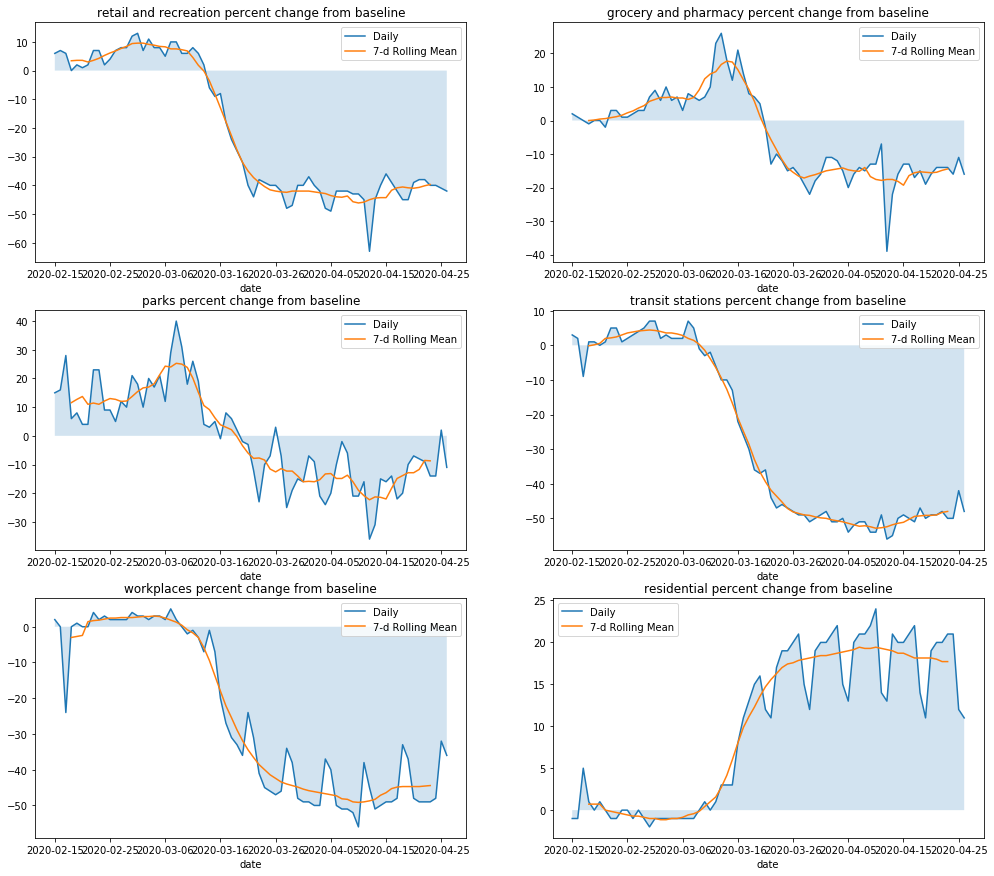

-------------------------------------------------------------------------------------------------------
Apple mobility data
-------------------------------------------------------------------------------------------------------


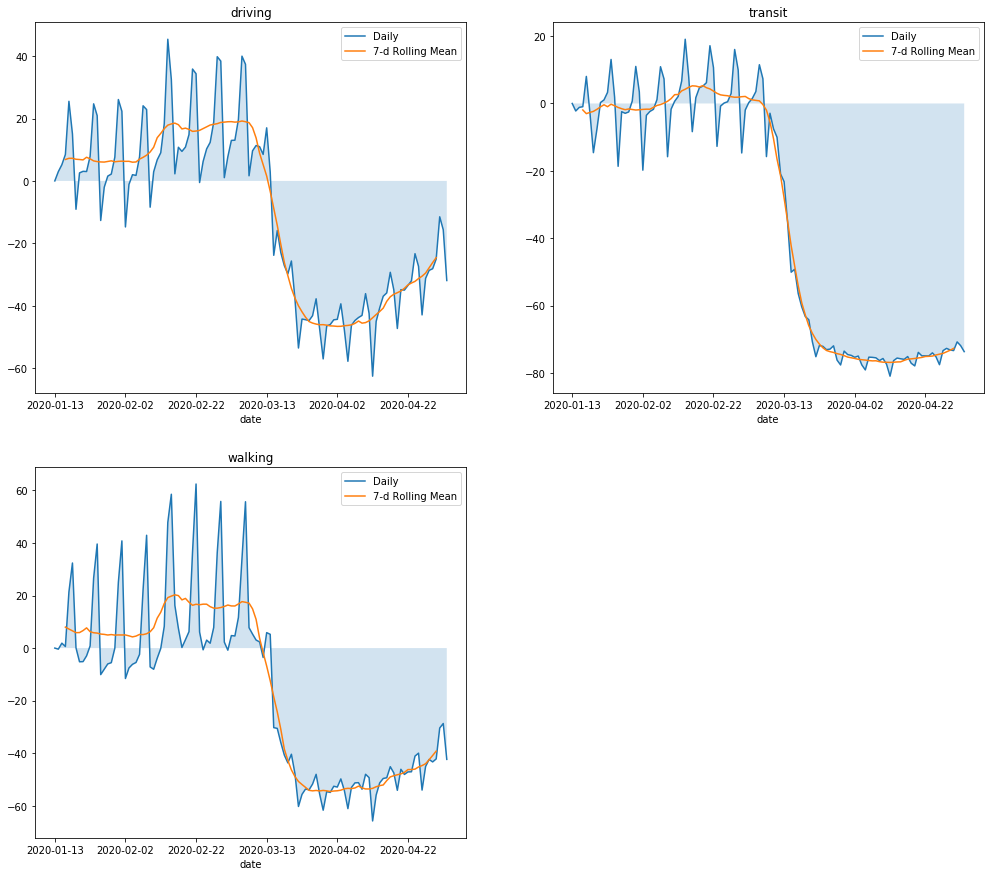

In [17]:
print("-------------------------------------------------------------------------------------------------------")
print("Google mobility data")
print("-------------------------------------------------------------------------------------------------------")
plot_daily_rolling(us_overall_google, data_columns_google)

print("-------------------------------------------------------------------------------------------------------")
print("Apple mobility data")
print("-------------------------------------------------------------------------------------------------------")
plot_daily_rolling(transposed_apple, data_columns_apple)

Notice how in both the Google and Apple mobility data, the trends start to drastically change from the baseline value around mid March which is when many states began moving into lockdown. We see many of the trends we expect to see. For instance, the residential trend increases, showing that more people are staying home than usual. This trend is a positive result of the lockdowns and shows that people are respecting social distancing guidelines.

With this EDA complete, we move forward to constructing an SIR model and forecasting different social distancing outcomes as time progresses.

## Methods

Our base model is an SIR model. In this section, we will define an SIR model, explain the modifications we made, and define and show the forecasted mobility data for three social distancing outcomes (staying in lockdown, slowly lifting lockdown, and immediately lifting lockdown).

**SIR Model**
An SIR model is a simple, compartmental model that can be used for disease modeling. We chose to modify this model because of the variables are easier to understand and explain and the derivatives are simple. We learned how to construct the model from [Henri Froese's *towards data science* article](https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4). The variables in our model are:

- **N:** total population
- **S(t):** number of people susceptible on day *t*
- **E(t):** number of people exposed on day *t*
- **I(t):** number of people infected on day *t*
- **R(t):** number of people recovered on day *t*
- **D(t):** number of people dead on day *t*
- **$\mathbf{\beta}$:** expected amount of people an infected person infects per day
- **D:** number of days an infected person has and can spread the disease
- **$\mathbf{\gamma}$:** the proportion of infected recovering per day ($\gamma = 1 / D$)
- **R$_0$:** the total number of people an infected person infects ($R_0 = \beta / \gamma$)
- **$\mathbf{\delta}$:** length of incubation period
- **$\mathbf{\alpha}$:** fatality rate
- **$\mathbf{\rho}$:** rate at which people die ($\rho = 1 / $ days from infected until death)

### -- SIR Model Definition

In [18]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    '''
    Find the derivatives necessary to calculate the SIR model changes
    '''
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def deriv_original(y, t, N, beta, gamma, delta, alpha, rho):
    '''
    Find the derivatives necessary to calculate the SIR model changes (when beta is constant)
    '''
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [19]:
################### SIR COEFFICIENT ESTIMATES FROM EXTERNAL SCHOLARLY WORK ###################
N = 328.2 * 10**6 # Total population
# https://www.health.harvard.edu/diseases-and-conditions/if-youve-been-exposed-to-the-coronavirus
# mild infection seems to last one - two weeks, typically infectious 48 - 72 hours before showing symptoms
D = 14.0
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

# initial R_0 estimate https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
initial_r_0 = 5.7

alpha = 0.05  # 5% death rate (estimated from current US statistics, we are taking the lower estimate 
# because there are probably a lot of asymptomatic cases that are not identified)
rho = 1 / 9  # 9 days from infection until death
###################

The above coefficients to the SIR model are estimated values from papers published about COVID-19. Since this epidemic is new and ongoing, it is hard to estimate the true values. The model can be updated later on if improved estimates come forward.

The main modification that we make to the SIR model is to the $R_0$ value. In a world without social distancing, it is estimated that $R_0 \approx 5.7$. This value is our initial $R_0$. However, social distancing measures should *reduce* the number of people that an infected person infects because they are in contact with less people overall. Therefore, the mobility data presents a proxy for the $R_0$ because the data shows how the movement of people changes. 

We assign weights to each mobility column where a positive weight reflects a beneficial outcome if the change from baseline is positive (such as staying home). A negative weight reflects a beneficial outcome if the change from baseline is negative (such as transit). The weights have been tuned to reflect the ability of each column to abide social distancing precautions and to match with the true U.S. data. For example, since grocery and pharmacy stores are a necessity and are working to maintain social distancing precautions, the weight is lower than for retail and recreation which is not a necessity and is not necessarily working to maintain social distancing precautions.

In [20]:
# weights per category of mobilitity in each dataset
# these parameters were chosen based on the effect of each category on the spread of the disease
# because apple had fewer categories the weights needed to be on a smaller scale for the volume to be comparable
google_weights = [-1, -0.5, -0.5, -1, -1, 2]
apple_weights = [-0.75, -0.75, -0.75]

In [21]:
# TODO - update R_0 for social distancing forecasts

def R_0(t, initial_r_0, coefs, mobility_df, data_columns):
    '''
    Uses U.S. mobility data as a proxy to find the adjusted R_0 value for Covid-19 in the U.S.
    
    t: time, integer value starting from 0 where 0 = January 21, 2020
    initial_r_0: the initial R_0 value (estimated from https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)
    coefs: the weights for each type of mobility category
    mobility_df: the mobility dataframe (shows percent change from baseline value)
    data_columns: the mobility categories
    
    returns: an adjusted R_0 value
    '''
    
    mobility_df = mobility_df.dropna()

    r_0 = initial_r_0
    r_0_change = 0
    
    # first day recorded, last day recorded
    max_data_idx = len(mobility_df) - 1
    
    # Match the mobility data time scale to the model time scale 
    # (this will need to be adjusted with the forecasted mobility models)
    data_idx_delta = (pd.to_datetime('2020-01-21') - pd.to_datetime(mobility_df.iloc[0].name)).days
    adjusted_t = int(t + data_idx_delta)
    
    if adjusted_t >= 0 and adjusted_t <= max_data_idx:
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * mobility_df.iloc[adjusted_t][col] / 100
        r_0 -= r_0_change
        
    elif adjusted_t > max_data_idx:
        ## TODO - add the forecasted model here (elif becomes else and value is drawn from forecasted model)
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * mobility_df.iloc[max_data_idx][col] / 100
        r_0 -= r_0_change
    return max(r_0, 0) 

def beta_google(t):
    return R_0(t, initial_r_0, google_weights, us_overall_7d_google, data_columns_google) * gamma

def beta_apple(t):
    return R_0(t, 5.7, apple_weights, us_overall_7d_apple, data_columns_apple) * gamma

### -- Social Distancing Forecasts

With the modified SIR model defined, we now wish to apply the model to different social distancing outcomes. To do so, we forecast three different scenarios from the current mobility data: staying in lockdown, slowly lifting lockdown, and immediately lifting lockdown. We extend these forecasts out a year, but to produce accurate results, the forecasts should be continuously updated and should only predict about a month or so in the future. We also recognize that these forecasts do not include seasonality changes. In order to produce a better forecast, we could use the data from a year prior (if that data was available to us) and adjust the values according to social distancing measures. However, since we do not have this data, we will continue with the basic forecasts shown below.

In [22]:
# drop unecessary columns for mobility data
google_us_thinned = google_us.drop(columns=['country_region_code', 'country_region',
                                            'sub_region_1', 'sub_region_2'])

# separate mobility data into before and after lockdown
before_lockdown_mask = (google_us_thinned['date'] <= '2020-03-20')
lockdown_mask = (google_us_thinned['date'] > '2020-03-20')
us_before_lockdown = google_us_thinned.loc[before_lockdown_mask]
us_in_lockdown = google_us_thinned.loc[lockdown_mask]

# pick out obility data before the spread of covid spiked in the US
before_spread_mask = (google_us_thinned['date'] <= '2020-03-12')
us_before_spread = google_us_thinned.loc[before_spread_mask]

In [23]:
def forecast_mobility(mobility_data, days, mobility_columns):
    
    forecasts = []
    fig = plt.figure(figsize=(20,17))
    
    last_date = mobility_data.iloc[-1].date
    
    for i, col in enumerate(mobility_columns):
        google_col = mobility_data[['date', col]].rename(columns={'date':'ds', col:'y'})
        google_prophet = Prophet()
        google_prophet.fit(google_col)
        google_forecast = google_prophet.make_future_dataframe(periods=days, freq='D')
        google_forecast = google_prophet.predict(google_forecast)
        forecasts.append(google_forecast.yhat)
        google_prophet.plot(google_forecast, xlabel='Date', ylabel='mobility', ax=fig.add_subplot(3,2,i+1))
        plt.title(col)
        # google_prophet.plot_components(google_forecast) # this is for more info
        
    forecasts_df = pd.DataFrame(np.array(forecasts).T, columns=mobility_columns, index=google_prophet.make_future_dataframe(periods=days, freq='D').ds)
    forecasts_df = forecasts_df.reset_index().rename(columns={'ds':'date'})
    mask = (forecasts_df.date > last_date)
    forecasts_df = forecasts_df.loc[mask]

    return forecasts_df

In [24]:
def plot_combined_forecast(forecast, data_columns, title):
    plt.figure(figsize=(18,12))

    labels = ['Retail & Recreation', 'Grocery & Pharmacy', 'Parks', 'Transit Stations', 'Workplaces', 'Residential']
    for label, col in zip(labels, data_columns):
        forecast[col].plot(label = label) 

    day_delta = -(pd.to_datetime(forecast.iloc[0].name) - pd.to_datetime(google_us_thinned.iloc[-1].date)).days
    plt.axvline(day_delta, c='black', label='Forecast Begins')
    plt.xlabel('Date')
    plt.ylabel('Percent Change from Baseline')
    plt.legend()
    plt.title(title)
    plt.show()

In [25]:
# Cap data at 1.5 times the original max/min
def cap_data_forecast(forecast, data_columns):
    day_delta = -(pd.to_datetime(forecast.iloc[0].name) - pd.to_datetime(google_us_thinned.iloc[-1].date)).days
    for col in data_columns:
        max_cap = max(forecast[col].iloc[:day_delta]) * 1.5
        min_cap = min(forecast[col].iloc[:day_delta]) * 1.5
        forecast[col].iloc[np.where(forecast[col] > max_cap)] = max_cap
        forecast[col].iloc[np.where(forecast[col] < min_cap)] = min_cap
        
    return forecast

In [26]:
# Uncomment and run if CSV is not stored
# us_mobility_lockdown_forecast = google_us_thinned.append(forecast_mobility(us_in_lockdown, 300,
#                                                                            data_columns_google),ignore_index=True)

Forecast of Google Mobility in the US with Continued Current Lockdown Trend


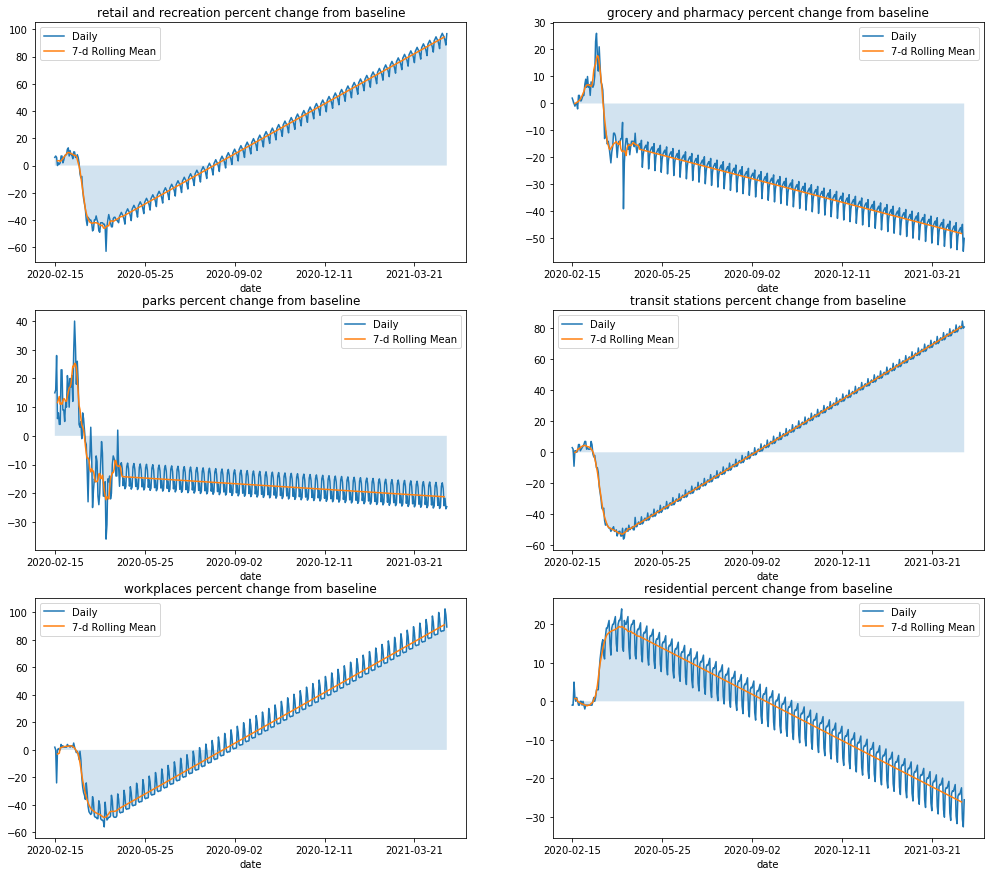

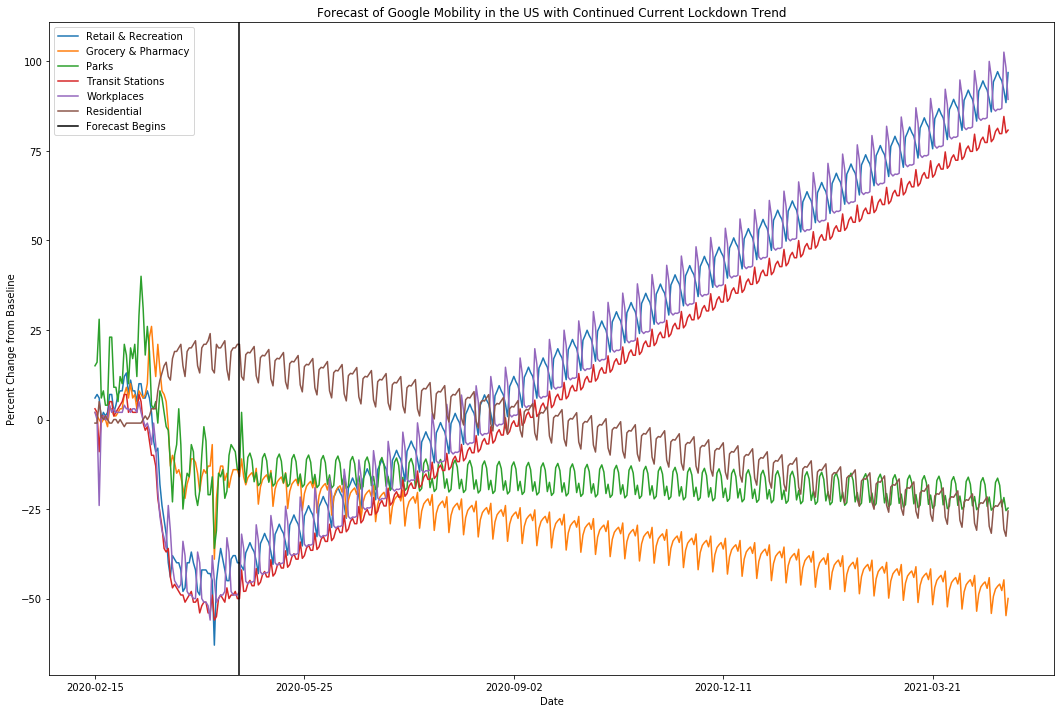

In [27]:
us_mobility_lockdown_forecast_google = pd.read_csv('nick/us_mobility_lockdown_forecast_google.csv').set_index('date')
print('Forecast of Google Mobility in the US with Continued Current Lockdown Trend')
plot_daily_rolling(us_mobility_lockdown_forecast_google, data_columns_google)

plot_combined_forecast(us_mobility_lockdown_forecast_google, data_columns_google, 'Forecast of Google Mobility in the US with Continued Current Lockdown Trend')

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Forecast of Google Mobility in the US with Continued Current Lockdown Trend, Capped


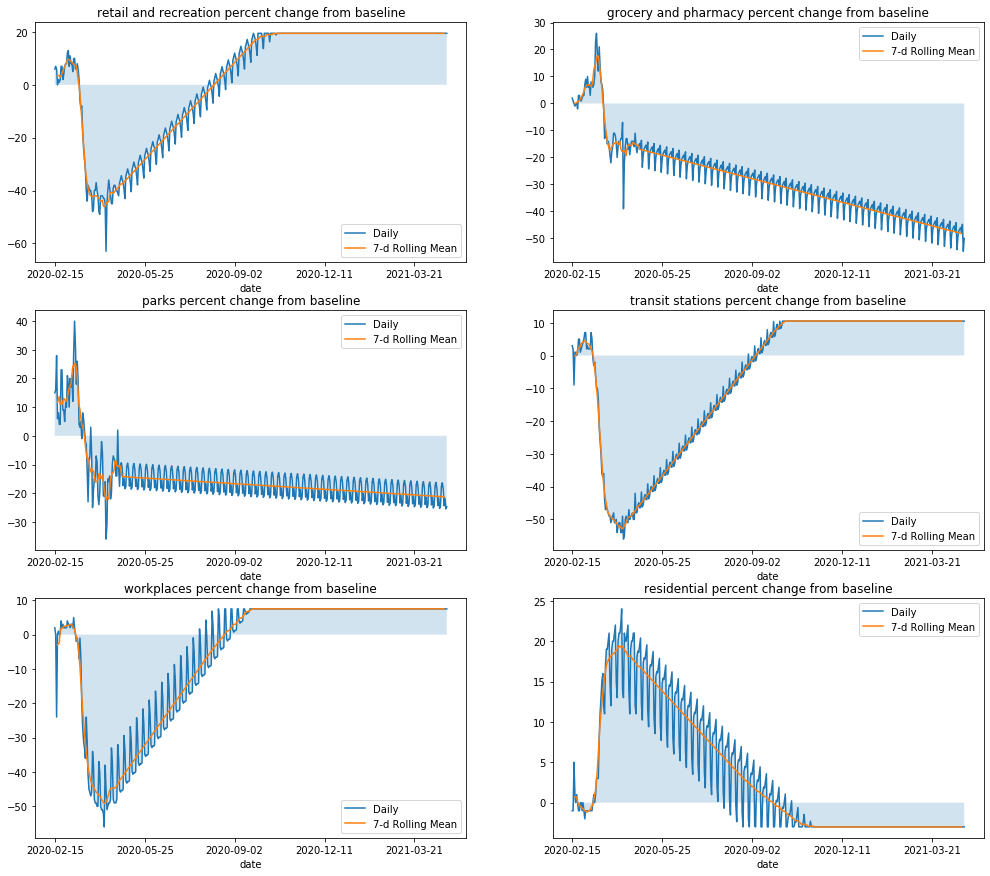

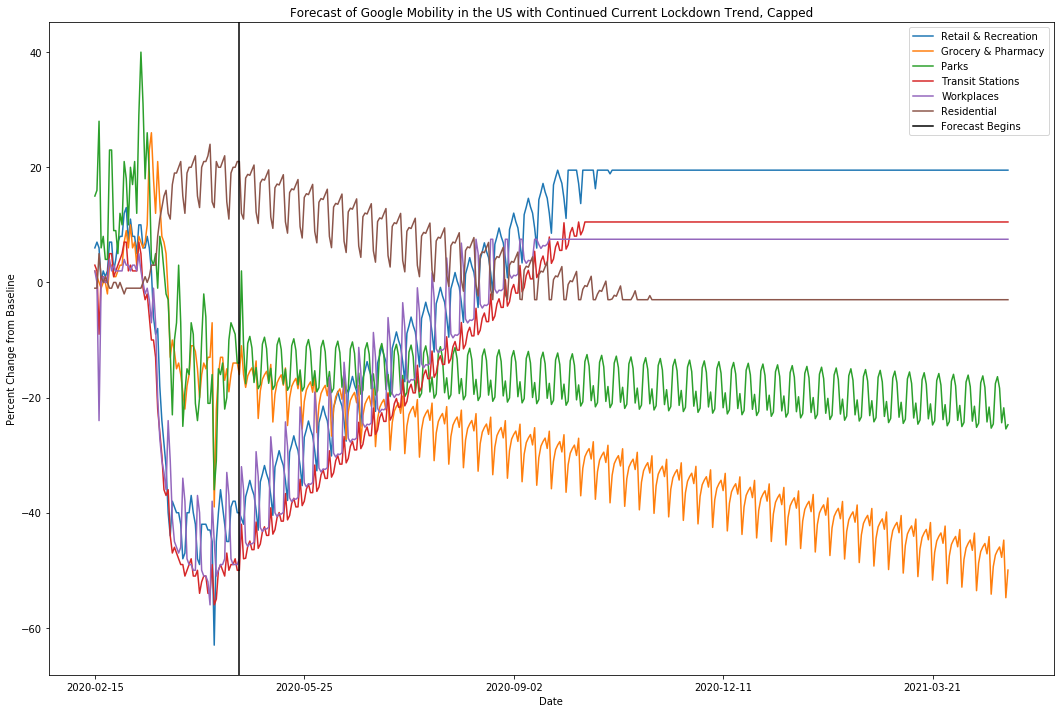

In [31]:
# Capped forecast
capped_lockdown_forecast_google = cap_data_forecast(us_mobility_lockdown_forecast_google, data_columns_google)
print('Forecast of Google Mobility in the US with Continued Current Lockdown Trend, Capped')
plot_daily_rolling(capped_lockdown_forecast_google, data_columns_google)

plot_combined_forecast(capped_lockdown_forecast_google, data_columns_google, 'Forecast of Google Mobility in the US with Continued Current Lockdown Trend, Capped')

Forecast of Google Mobility in the US with Lockdown Ended Immediately


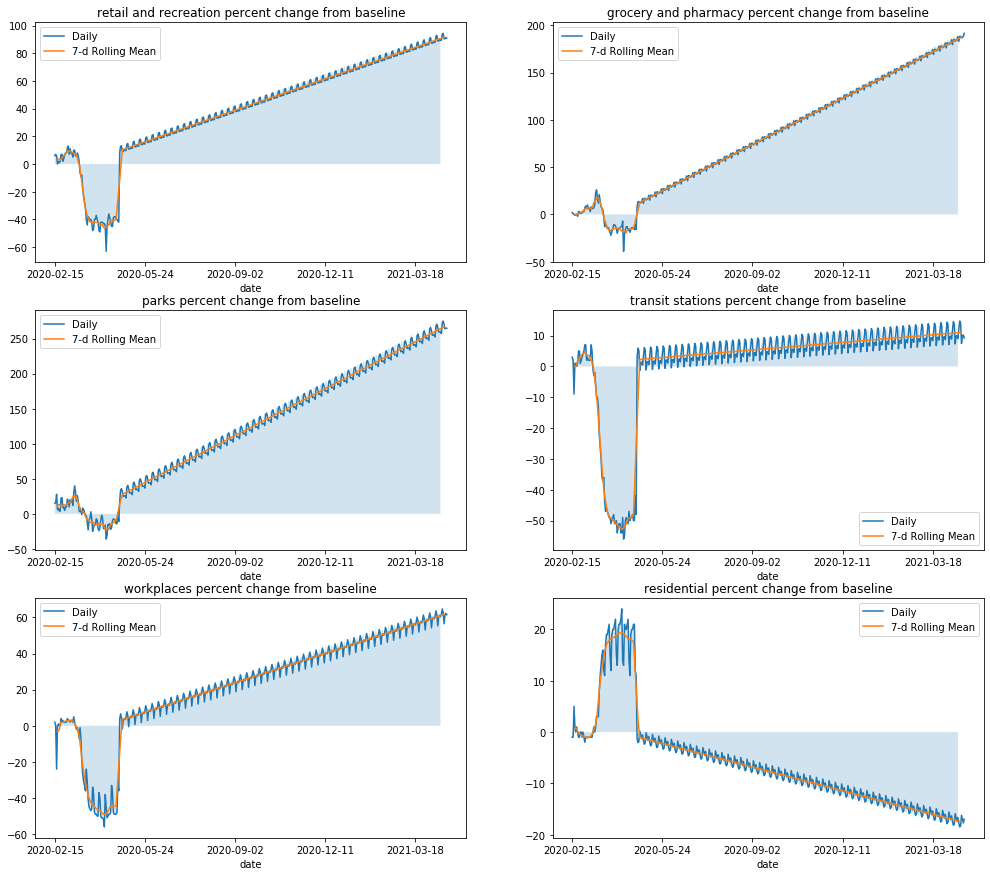

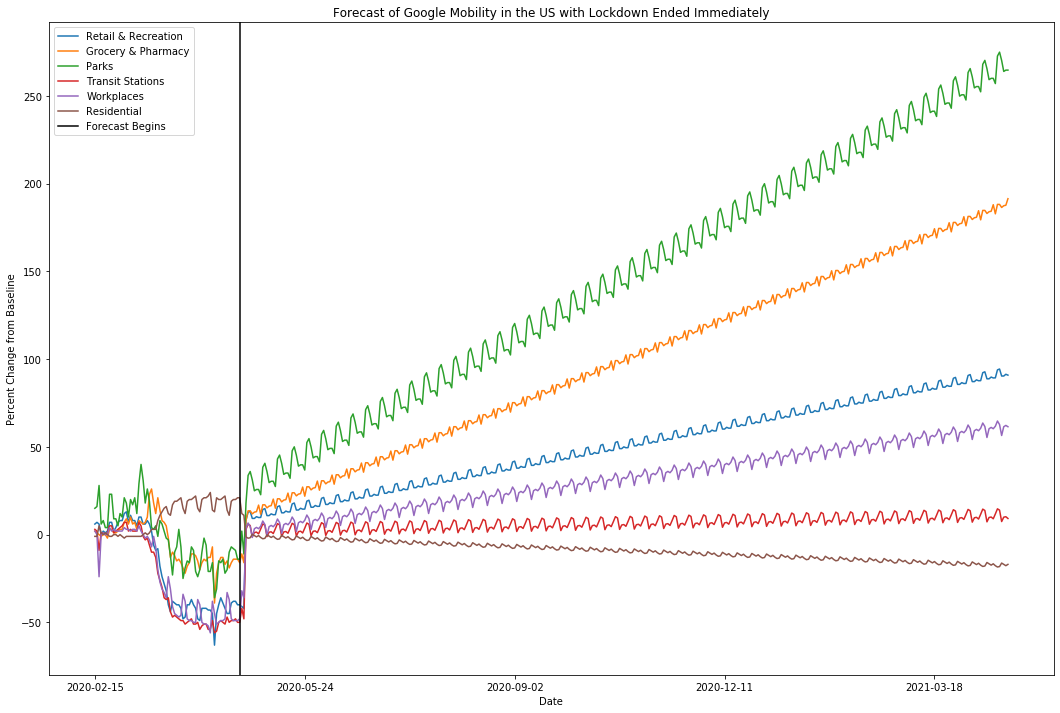

In [32]:
us_mobility_lockdown_ended_forecast_google = pd.read_csv('nick/us_mobility_lockdown_ended_forecast_google.csv').set_index('date')
print('Forecast of Google Mobility in the US with Lockdown Ended Immediately')
plot_daily_rolling(us_mobility_lockdown_ended_forecast_google, data_columns_google)

plot_combined_forecast(us_mobility_lockdown_ended_forecast_google, data_columns_google, 'Forecast of Google Mobility in the US with Lockdown Ended Immediately')

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Forecast of Google Mobility in the US with Lockdown Ended Immediately, Capped


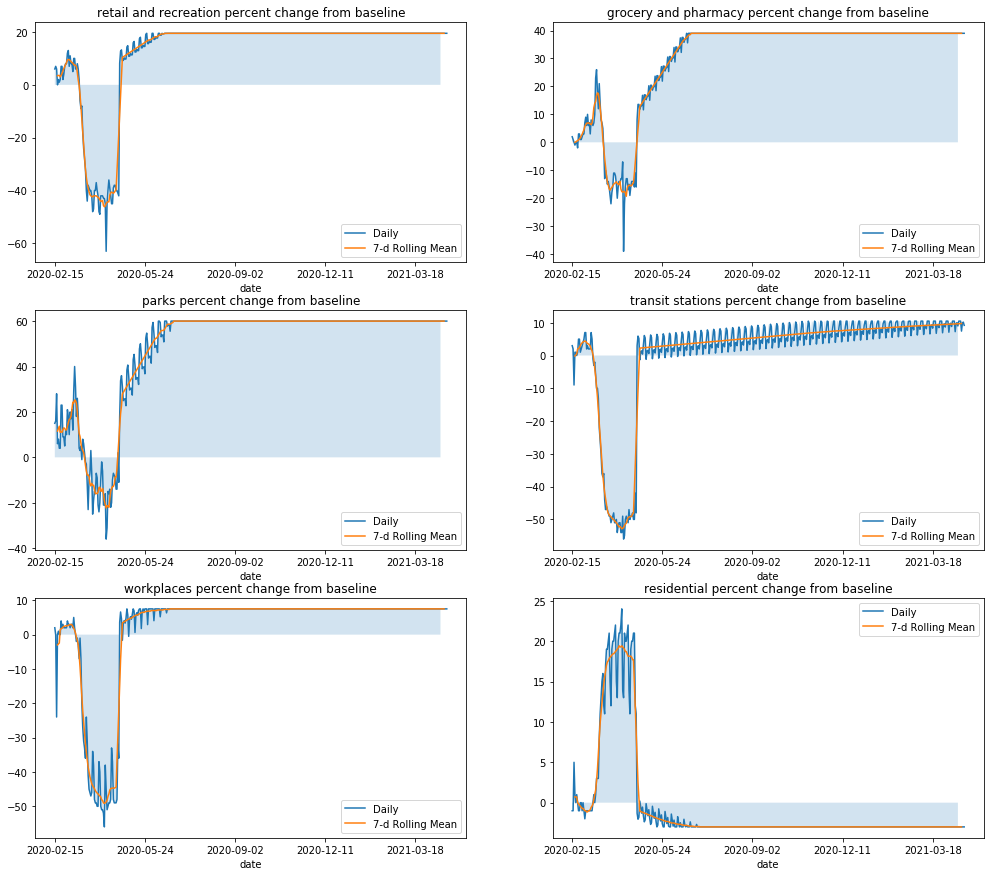

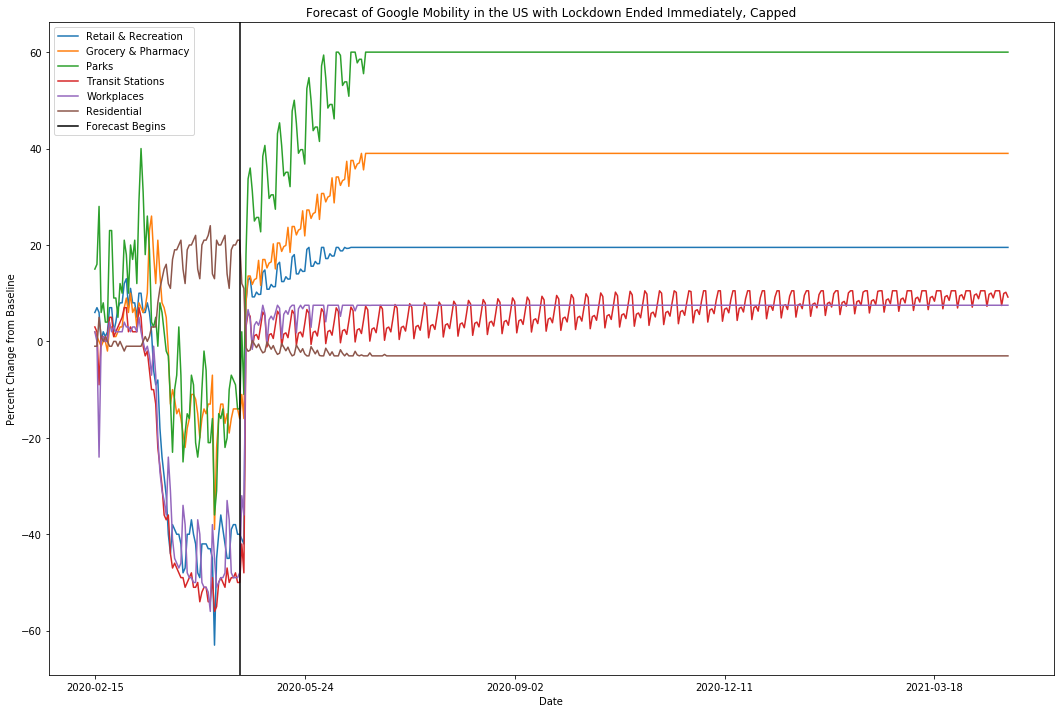

In [33]:
# Capped forecast
capped_lockdown_ended_forecast_google = cap_data_forecast(us_mobility_lockdown_ended_forecast_google, data_columns_google)
print('Forecast of Google Mobility in the US with Lockdown Ended Immediately, Capped')
plot_daily_rolling(capped_lockdown_ended_forecast_google, data_columns_google)

plot_combined_forecast(capped_lockdown_ended_forecast_google, data_columns_google, 'Forecast of Google Mobility in the US with Lockdown Ended Immediately, Capped')

Forecast of Apple Mobility in the US with Continued Current Lockdown Trend


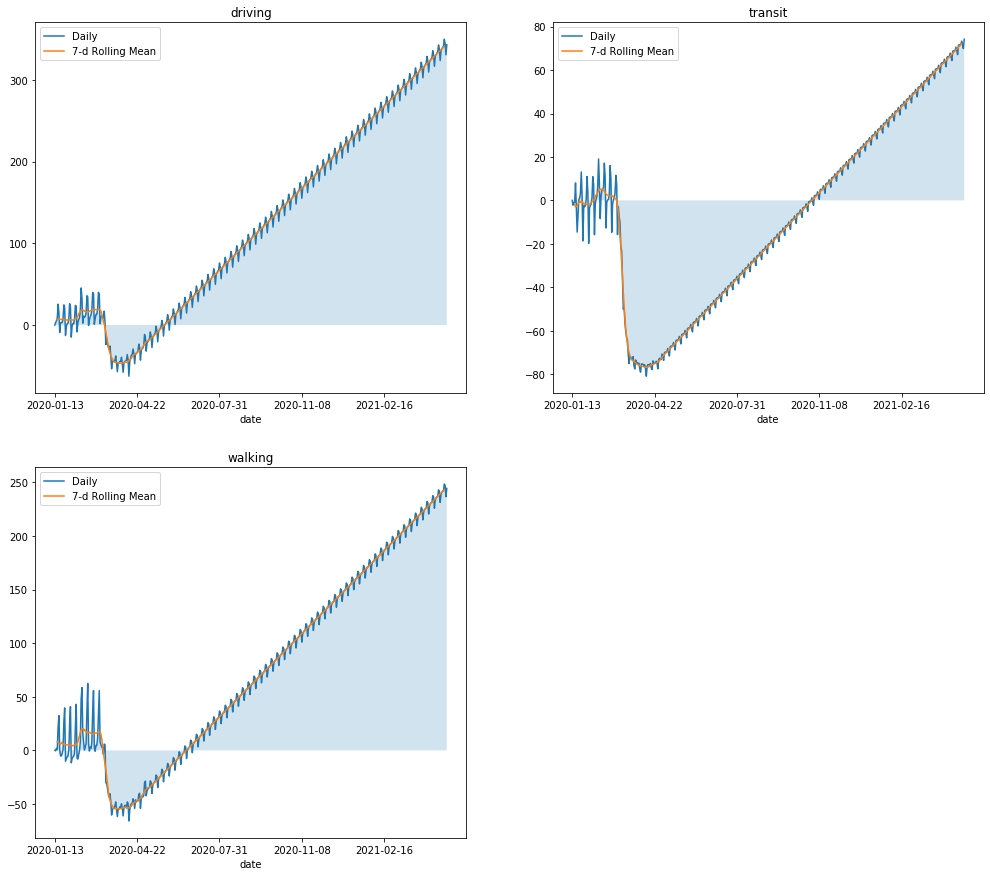

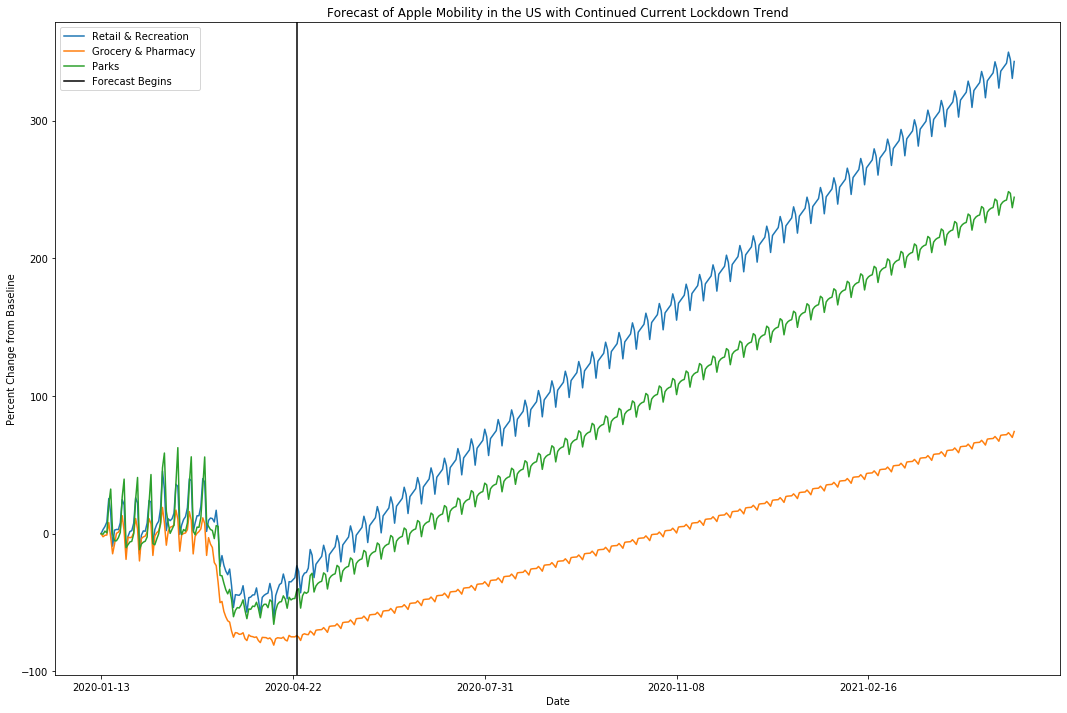

In [34]:
us_mobility_lockdown_forecast_apple = pd.read_csv('nick/us_mobility_lockdown_forecast_apple.csv').set_index('date')
print('Forecast of Apple Mobility in the US with Continued Current Lockdown Trend')
plot_daily_rolling(us_mobility_lockdown_forecast_apple, data_columns_apple)

plot_combined_forecast(us_mobility_lockdown_forecast_apple, data_columns_apple, 'Forecast of Apple Mobility in the US with Continued Current Lockdown Trend')

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Forecast of Apple Mobility in the US with Lockdown Ended Immediately, Capped


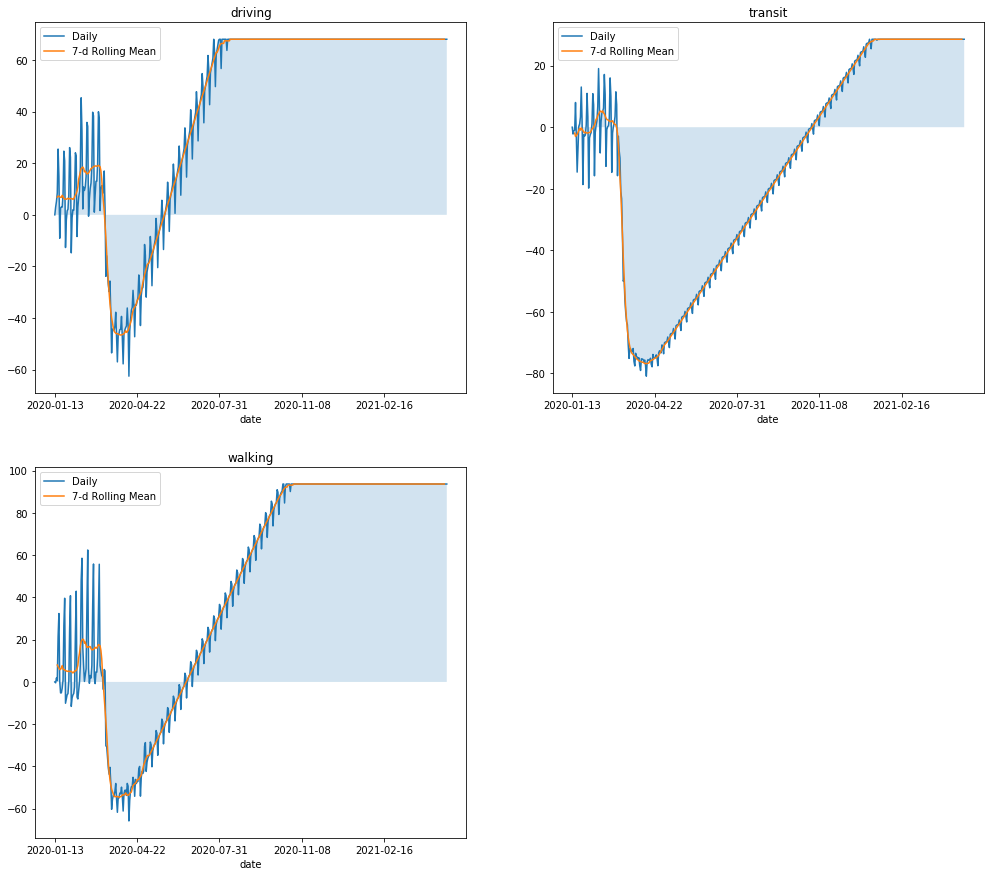

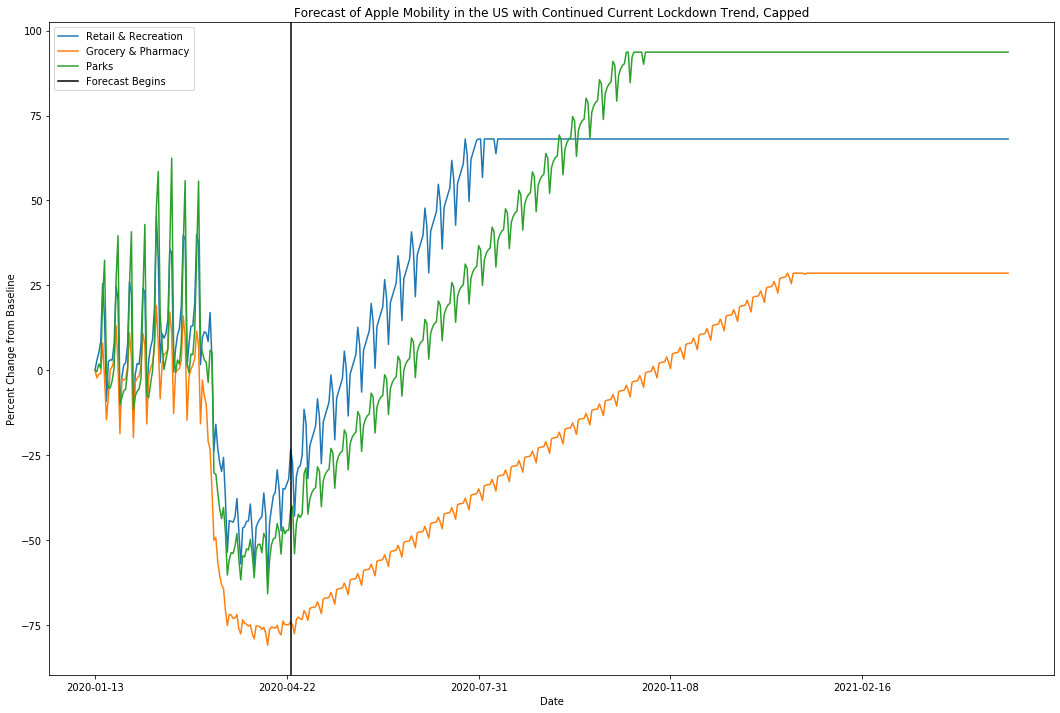

In [35]:
# Capped forecast
capped_lockdown_forecast_apple = cap_data_forecast(us_mobility_lockdown_forecast_apple, data_columns_apple)
print('Forecast of Apple Mobility in the US with Lockdown Ended Immediately, Capped')
plot_daily_rolling(capped_lockdown_forecast_apple, data_columns_apple)

plot_combined_forecast(capped_lockdown_forecast_apple, data_columns_apple, 'Forecast of Apple Mobility in the US with Continued Current Lockdown Trend, Capped')

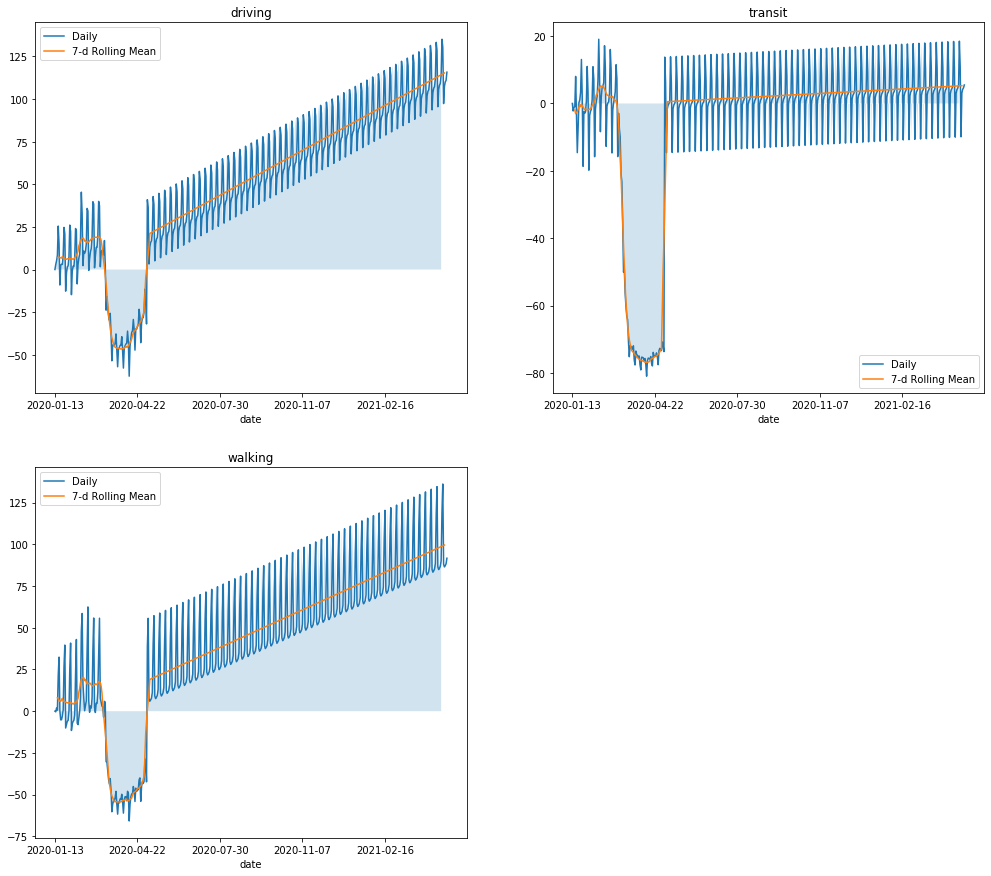

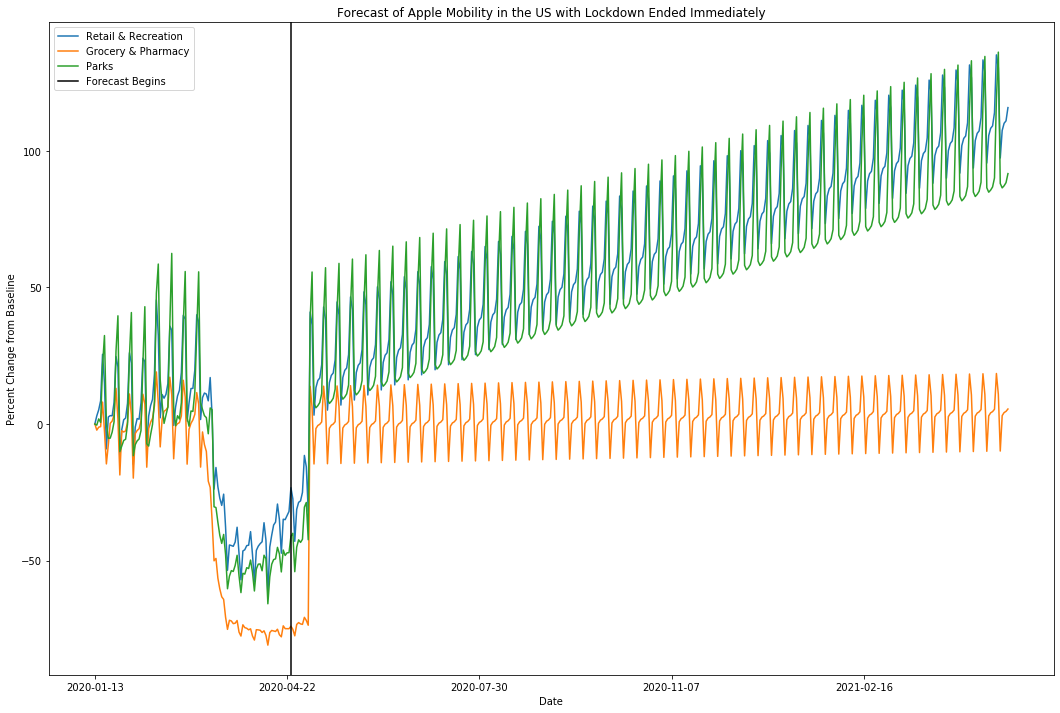

In [36]:
us_mobility_lockdown_ended_forecast_apple = pd.read_csv('nick/us_mobility_lockdown_ended_forecast_apple.csv').set_index('date')
plot_daily_rolling(us_mobility_lockdown_ended_forecast_apple, data_columns_apple)

plot_combined_forecast(us_mobility_lockdown_ended_forecast_apple, data_columns_apple, 'Forecast of Apple Mobility in the US with Lockdown Ended Immediately')

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Forecast of Apple Mobility in the US with Lockdown Ended Immediately, Capped


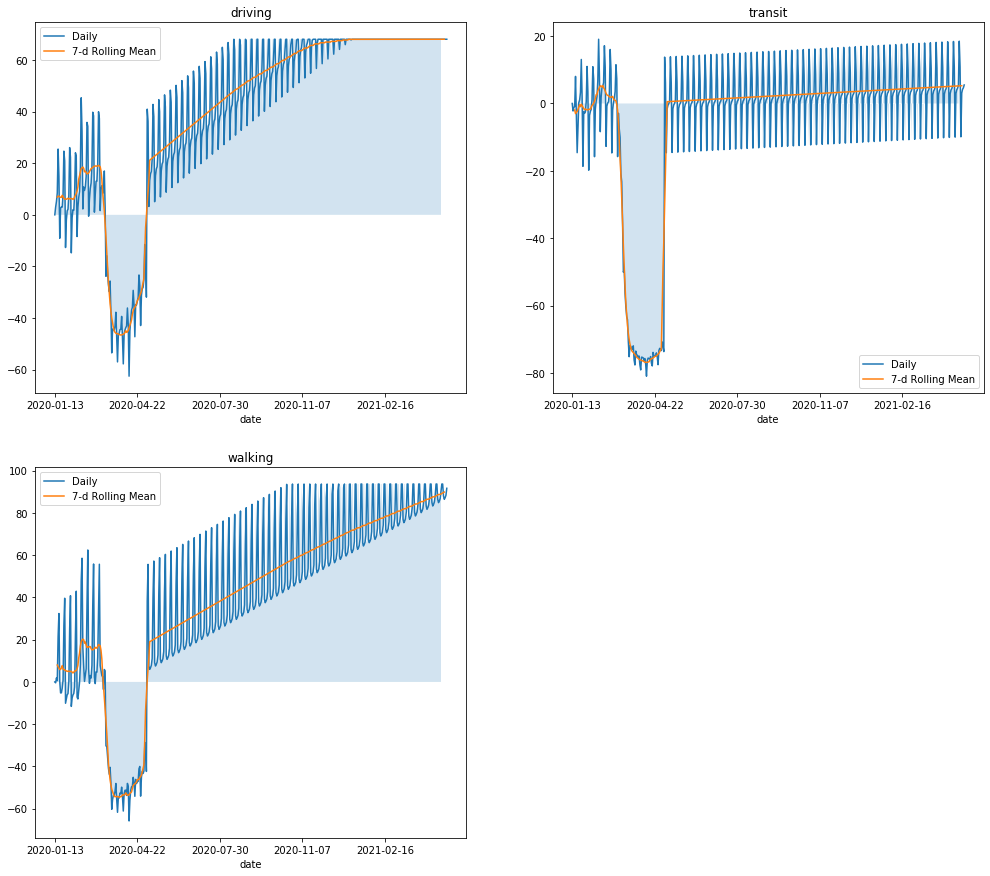

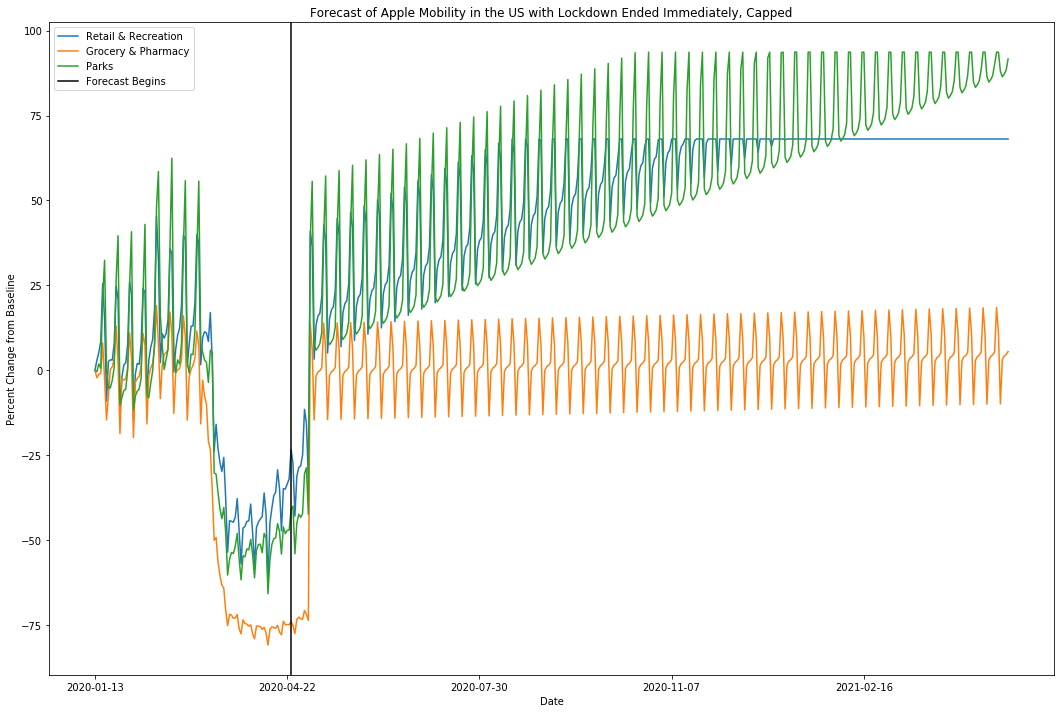

In [37]:
# Capped forecast
capped_lockdown_ended_forecast_apple = cap_data_forecast(us_mobility_lockdown_ended_forecast_apple, data_columns_apple)
print('Forecast of Apple Mobility in the US with Lockdown Ended Immediately, Capped')
plot_daily_rolling(capped_lockdown_ended_forecast_apple, data_columns_apple)

plot_combined_forecast(capped_lockdown_ended_forecast_apple, data_columns_apple, 'Forecast of Apple Mobility in the US with Lockdown Ended Immediately, Capped')

We use the above forecasts and capped forecasts to then predict corresponding $R_0$ values in the SIR model. The following sections show and discuss our findings. 

**Works Cited**
- [“The SIR Model for Spread of Disease - The Differential Equation Model.” The SIR Model for Spread of Disease - The Differential Equation Model | Mathematical Association of America.](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model)
- [Froese, Henri. “Infectious Disease Modelling: Beyond the Basic SIR Model.” Medium, Towards Data Science, 22 Apr. 2020.](https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4)
- [Harvard Health Publishing. “If You've Been Exposed to the Coronavirus.” Harvard Health.](https://www.health.harvard.edu/diseases-and-conditions/if-youve-been-exposed-to-the-coronavirus)
- [“Early Release - High Contagiousness and Rapid Spread of Severe Acute Respiratory Syndrome Coronavirus 2 - Volume 26, Number 7-July 2020 - Emerging Infectious Diseases Journal - CDC.” Centers for Disease Control and Prevention, Centers for Disease Control and Prevention.](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)
- [Estimating the number of undetected COVID-19 cases exported internationally from all of China](https://www.medrxiv.org/content/10.1101/2020.03.23.20038331v2)

## Results

TODO - add words

### -- Plotting Functions

In [38]:
def plotseird(t, S, E, I, R, D):
    '''
    Plot the SIR model defined by the S (susceptible), E (exposed), I (infected), R (recovered), D (dead) arrays 
    '''
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

In [39]:
def plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    '''
    Plot two SIR models
    '''
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax.plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax.plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax.plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax.plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax.plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

In [40]:
def plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    '''
    Plots subplots of each curve to observe difference between original and adjusted model
    '''
    f, ax = plt.subplots(3,2,figsize=(20,17))
    ax[2, 0].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 0].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[0, 0].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[0, 0].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[0, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[0, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[1, 0].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[1, 0].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[1, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[1, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')

    ax[2, 1].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 1].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[2, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[2, 1].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[2, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[2, 1].plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax[2, 1].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[2, 1].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[2, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[2, 1].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[2, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')
    ax[2, 1].plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    
    
    for a in ax:  
        for i in range(2):
            a[i].set_xlabel('Time (days)')
            a[i].yaxis.set_tick_params(length=0)
            a[i].xaxis.set_tick_params(length=0)
            a[i].grid(b=True, which='major', c='w', lw=2, ls='-')
            legend = a[i].legend()
            legend.get_frame().set_alpha(0.5)
            for spine in ('top', 'right', 'bottom', 'left'):
                a[i].spines[spine].set_visible(False)
    plt.show();

Let us first visualize the original SIR model with $R_0 = 5.7$. This corresponds to a scenario with no social distancing measures taken.

No Social Distancing, (R_0 stays constant at 5.7)


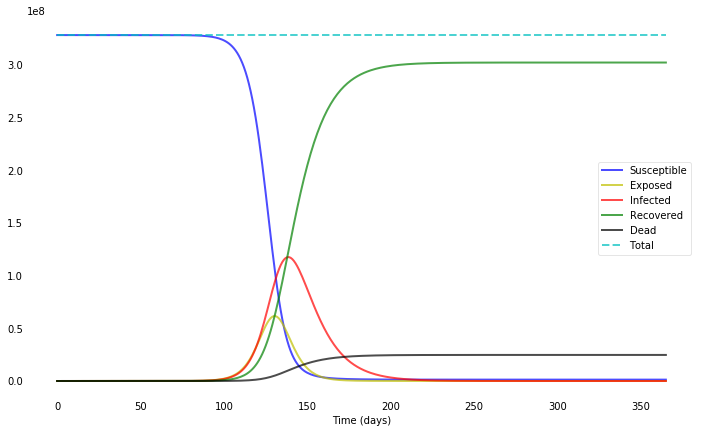

In [41]:
# initial conditions: one exposed
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  
y0 = S0, E0, I0, R0, D0 

# Grid of time points (in days), observe a one year period
t = np.linspace(0, 365, 366) 

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_original, y0, t, args=(N, 5.7 * gamma, gamma, delta, alpha, rho))
S_orig, E_orig, I_orig, R_orig, D_orig = ret.T

print("No Social Distancing, (R_0 stays constant at 5.7)")
plotseird(t, S_orig, E_orig, I_orig, R_orig, D_orig)

Now, we can visualize the different social distancing scenarios for both the Google and Apple mobility data.

Social Distancing, (Google mobility data for R_0 proxy)


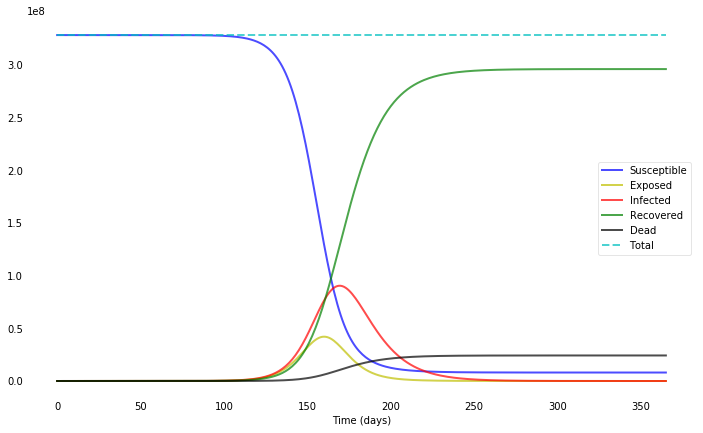

In [42]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_google, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

print("Social Distancing, (Google mobility data for R_0 proxy)")
plotseird(t, S, E, I, R, D)

Google mobility model overlayed with original model


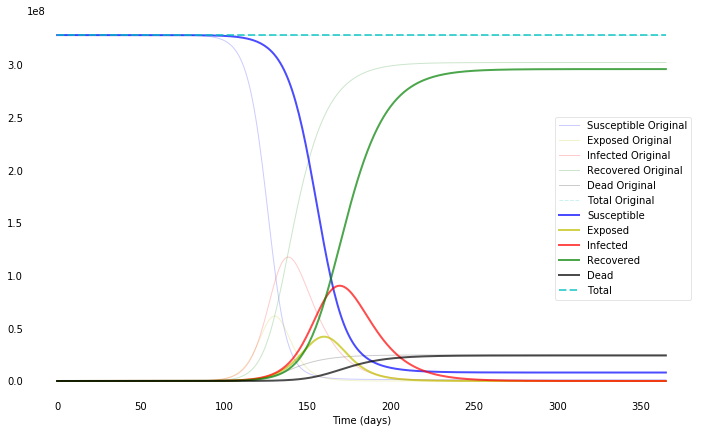

In [43]:
print("Google mobility model overlayed with original model")
plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

Looking at the compared models above, we see that even with social distancing measures the total number of deaths eventually reaches approximately the same number. This is because our model does not take into account hospital capacity, which, when overloaded, leads to many more (preventable) deaths. Thus we can infer from the flattened infected curve, that the burden on hospitals will not be as large with limited mobility, and thus some deaths will be prevented.

Social Distancing, (Apple mobility data for R_0 proxy)


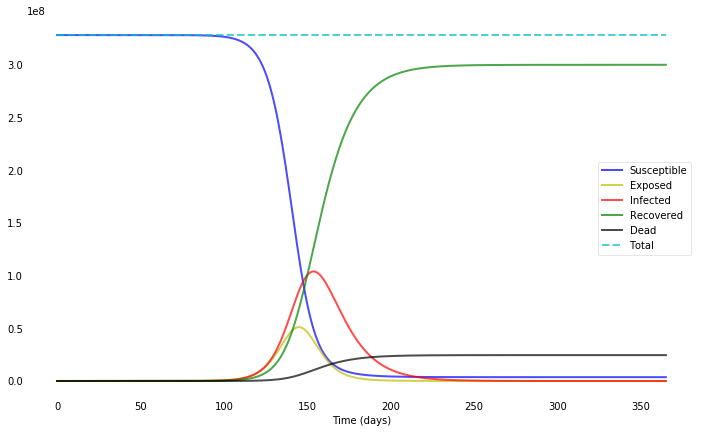

In [44]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_apple, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

print("Social Distancing, (Apple mobility data for R_0 proxy)")
plotseird(t, S, E, I, R, D)

Apple mobility model overlayed with original model


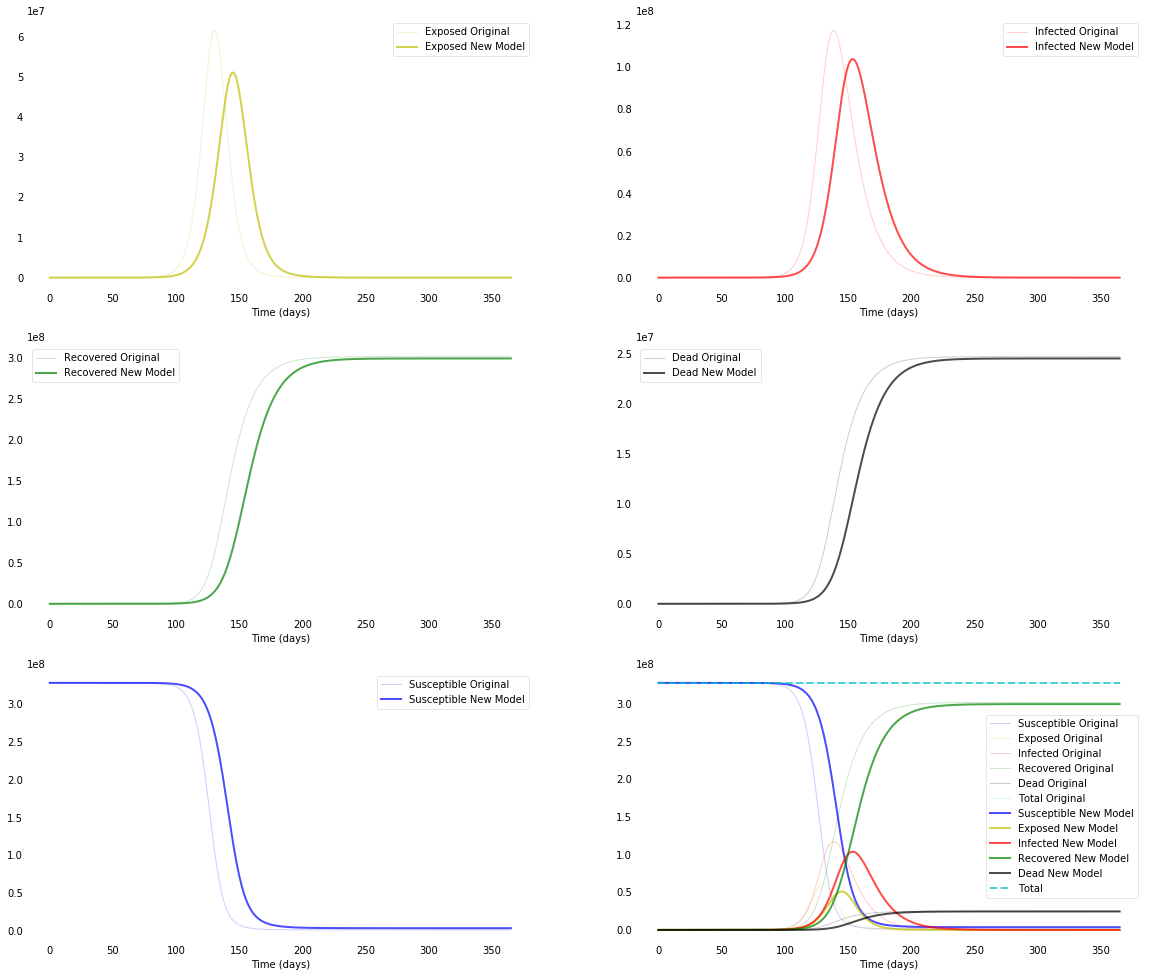

In [45]:
print("Apple mobility model overlayed with original model")
plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

As we can see above, the Apple mobility data also indicates that social distancing measures have had a flattening effect on the infected curve, and if we continue at this level of mobility, the infected curve will remain flattened. 

Next we can run the SIR model with the forcasted data:

In [48]:
def beta_goog_forecast(t):
    return R_0(t, initial_r_0, google_weights, us_mobility_lockdown_forecast_google, data_columns_google) * gamma

def beta_appl_forecast(t):
    return R_0(t, 5.7, apple_weights, us_mobility_lockdown_forecast_apple, data_columns_apple) * gamma

Social Distancing, (Apple mobility data for R_0 proxy)


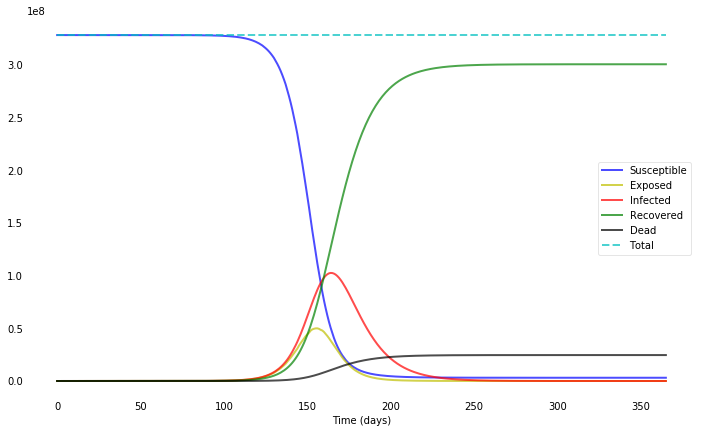

In [49]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_goog_forecast, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

print("Social Distancing, (Apple mobility data for R_0 proxy)")
plotseird(t, S, E, I, R, D)

## Discussion

TODO - add final conclusion and discussion

Moving forward ideas:
- use more sophisticated forecasting techniques (include seasonality, difference from a year prior)
- include other countries, currently we are treating the U.S. as if no other country can affect it
- include worldwide mobility data (air traffic, etc.)